# Initialization

In [1]:
USE_MP = True
import silq

silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Initializing layout
Initializing data
Initializing analysis
Initializing parameters
Initializing plotting
Initialization complete
Attempting to halt background measurement without termination
Attempting to halt background measurement without termination
Attempting to halt background measurement without termination
Attempting to halt background measurement without termination
Attempting to halt background measurement without termination


In [2]:
calibration_operations = [
    {'mode': 'measure'},
    {'mode': '1D_scan', 'span': 0.007, 'set_points': 12, 'set_parameter': 'DF_DS'},
    {'mode': '1D_scan', 'span': 0.015, 'set_points': 25, 'set_parameter': 'DF_DS'}]
conditions =  [('contrast', 0.4, '>')]
autocal_parameter = measurement_parameters.CalibrationParameter(
    name='autocal', set_parameters=[DF_DS], acquisition_parameter=adiabatic_ESR_parameter, 
    operations=calibration_operations, discriminant='contrast', conditions=conditions)

In [5]:
def create_set_vals(mode, spans=None, span_vals=None, nums=10, set_parameters=None):
    def get_span(k, set_parameter):
        if spans is not None:
            if hasattr(spans, "__iter__"):
                span_idx = spans[k]
            else:
                span_idx = spans
            span = properties_config['set_parameters'][set_parameter.name]['spans'][span_idx]
        elif span_vals is not None:
            if hasattr(spans, "__iter__"):
                span = span_vals[k]
            else:
                span = span_vals
        return span
    
    if set_parameters is None:
        set_parameters_names = properties_config['set_parameters'][mode]
        set_parameters = [getattr(station, name) for name in set_parameters_names]

    set_vals = []
    if mode == '2D':
        if not hasattr(nums, "__iter__"):
            nums = [nums] * len(set_parameters)
        for k, set_parameter in enumerate(set_parameters):
            span = get_span(k, set_parameter)
            center_val = set_parameter()
            vals = list(np.linspace(center_val - span/2, center_val + span/2, nums[k]))
            set_vals.append(set_parameter[vals])
    return set_vals

def terminate_servers():
    for server in active_children():
        server.terminate()

## Threshold voltage

In [ ]:
EPR_parameter.single_settings(samples=50)
EPR_parameter.setup()
voltage_difference = EPR_parameter()[-1]

assert voltage_difference, "Couldn't find accurate threshold"
readout_threshold_voltage = voltage_difference / 2

print('Threshold voltage found at {:.2f} V'.format(readout_threshold_voltage))
properties_config['readout_threshold_voltage'] = readout_threshold_voltage

## ESR frequency

In [ ]:
select_ESR_parameter.single_settings(samples=30, silent=False)
select_ESR_parameter();

# DC Measurements

## DC - Turnon
Here several gates are combined to the parameter turnon_param.

In [ ]:
turnon_vals = turnon_parameter[list(np.linspace(1, 1.6, 100))]

In [ ]:
DC_parameter.setup()
data = qc.Loop(turnon_vals
# data = qc.Loop(dummy_parameter[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='turnon',
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

## DC - Pinchoff
This code pinches off one gate, while keeping the other gates fixed

In [ ]:
turnon_voltage = 1.6
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 100))
gate = TG

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

In [ ]:
turnon_voltage = 1.3
pinchoff_vals = list(np.linspace(turnon_voltage, 0.7, 40))
gatex=LB
gatey=RB

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gatey[pinchoff_vals]
               ).loop(gatex[pinchoff_vals]
                      ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='2D_Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)


## DC - 1D scan
This script performs a 1D DC scan

In [ ]:
gate = DF_DS[list(np.linspace(0.28,0.6, 50))]

DC_parameter.setup()
data = qc.Loop(gate
              ).each(DC_parameter
                    ).then(qc.Task(layout.stop)
                          ).run(name='DC_{}_scan'.format(gate.name),
                                progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

## DC - 2D scan

This measurement performs a 2D DC scan

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-21/#001_DC_TGAC_vs_DF_DS_scan_07-14-23'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (35,)
   Setpoint | DF_DS_set  | DF_DS        | (35, 35)
   Measured | DC_voltage | DC_voltage   | (35, 35)
started at 2016-12-21 07:14:26


<IPython.core.display.Javascript object>


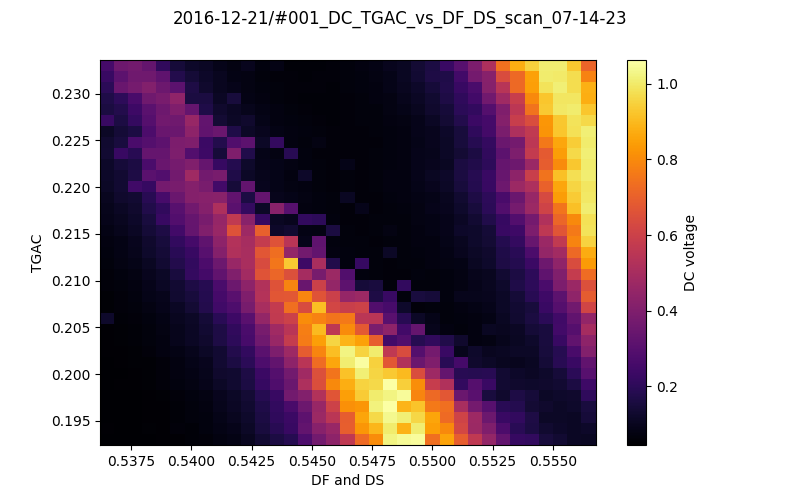

In [39]:
y_sweep, x_sweep = create_set_vals('2D', spans=3, nums=35)
DC_parameter.setup()
data = qc.Loop(
    y_sweep).loop(
    x_sweep).each(
    DC_parameter).then(
    qc.Task(layout.stop)).run(
    name='DC_{}_vs_{}_scan'.format(y_sweep.name, x_sweep.name),
    progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

# EPR measurements (no steering/ESR)

This is a calibration routine to find a point with high contrast (difference in signal between up state and down state). 
This measurement consists of three stages: empty, load, and read.
In the empty stage, the donor atom is ionized. 
It is then loaded with an electron in a random state.
Finally the state is read out for a long duration.
The contrast is found by looking if blips occured at the beginning of the read trace and at the end of the read trace.
The contrast is the difference in percentage of blips occuring at the beginning versus at the end.
The end part of the read trace is related to the number of dark counts, since we assume that an up-state electron will have had enough time to have tunneled off and on again.

## EPR - 2D scan

In [3]:
DF_DS(0.546)
TGAC(0.219)

In [26]:
y_sweep, x_sweep = create_set_vals('2D', spans=0, nums=5)

In [27]:
EPR_parameter.settings(samples=150)
data = qc.Loop(
    y_sweep).loop(
    x_sweep).each(
    EPR_parameter).run(
    name='EPR_calibration', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-20/#023_EPR_calibration_20-19-11'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | TGAC_set           | TGAC               | (5,)
   Setpoint | DF_DS_set          | DF_DS              | (5, 5)
   Measured | contrast           | contrast           | (5, 5)
   Measured | dark_counts        | dark_counts        | (5, 5)
   Measured | voltage_difference | voltage_difference | (5, 5)
   Measured | fidelity_empty     | fidelity_empty     | (5, 5)
   Measured | fidelity_load      | fidelity_load      | (5, 5)
started at 2016-12-20 20:19:19


<IPython.core.display.Javascript object>


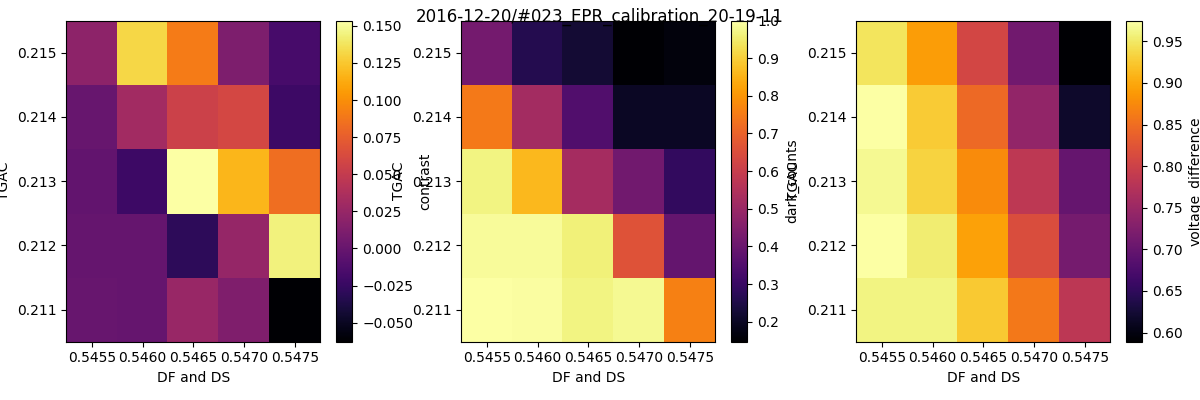

In [28]:
plot = qc.MatPlot(subplots=(1, 3), figsize=(12, 4))
plot.add(data.contrast, subplot=1)
plot.add(data.dark_counts, subplot=2)
plot.add(data.voltage_difference, subplot=3)
plt.tight_layout()

## EPR - Single point

In [12]:
EPR_parameter.single_settings(samples=150, silent=False)
EPR_parameter();

contrast: 0.043
dark_counts: 0.760
voltage_difference: 0.251
fidelity_empty: 0.000
fidelity_load: 0.000


# Adiabatic sweep measurements

## ESR Adiabatic - Center frequency scan

This code sweeps over the adiabatic sweep center frequency to find the ESR frequency.

To find the ESR frequency, use 28GHz * B0 as starting point, and search around that frequency.
Use a big initial frequency_deviation (around 60 MHz) and long duration (0.5 ms)
Once you see a spike in contrast, center around there and decrease both deviation and duration.

In [ ]:
f_center = frequency_center_ESR['down']
f_span = 5e6
f_step = 0.25e6
adiabatic_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(adiabatic_sweep_vals)))

In [ ]:
adiabatic_ESR_parameter.setup(samples=80)
data = qc.Loop(adiabatic_ESR_parameter[adiabatic_sweep_vals]
                     ).each(adiabatic_ESR_parameter
                           ).run(name='adiabatic_ESR_f_center',
                                progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

## NMR adiabatic frequency scan

In [ ]:
#NMR sweep frequencies
f_center = 66.82e6
f_span = 3e6
f_step = 20e3
NMR_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(NMR_vals)))

In [ ]:
data = qc.Loop(adiabatic_NMR_parameter[NMR_vals]
              ).each(qc.Task(adiabatic_NMR_parameter.setup),
                     adiabatic_NMR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['up'])),
                     adiabatic_ESR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['down'])),
                     adiabatic_ESR_parameter,
                    ).run(name='NMR_adiabatic_sweep', progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_3_4)
plot.add(data.contrast_5_4)

## Adiabatic - frequency deviation versus ESR duration

This is a 2D scan of frequency deviation versus duration.
From this measurement, the minimum acceptable values for frequency deviation and ESR duration can be extracted.

In [ ]:
pulse = adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')

adiabatic_deviation_vals = list(np.logspace(5.5, 7.8, 8))
adiabatic_duration_vals = list(np.logspace(-2.7, -0.3, 8))

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['read'].duration = 100
adiabatic_sweep_parameter.setup(samples=400)
adiabatic_sweep_parameter(frequency_center)
data = qc.Loop(adiabatic_deviation_parameter[adiabatic_deviation_vals]
              ).loop(adiabatic_duration_parameter[adiabatic_duration_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_deviation_vs_duration',
                                progress_interval=True)

In [ ]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
# for ax in plot.subplots:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Adiabatic - 2D scan

In [116]:
# TGAC, DF_DS sweep
y_sweep, x_sweep = create_set_vals('2D', spans=0, nums=8)

In [117]:
adiabatic_ESR_parameter.setup(samples=75)
data = qc.Loop(
    y_sweep).loop(
    x_sweep).each(
    adiabatic_ESR_parameter).run(
    name='adiabatic_calibration', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-22/#001_adiabatic_calibration_09-41-26'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | TGAC_set           | TGAC               | (8,)
   Setpoint | DF_DS_set          | DF_DS              | (8, 8)
   Measured | contrast           | contrast           | (8, 8)
   Measured | dark_counts        | dark_counts        | (8, 8)
   Measured | voltage_difference | voltage_difference | (8, 8)
started at 2016-12-22 09:41:34


<IPython.core.display.Javascript object>


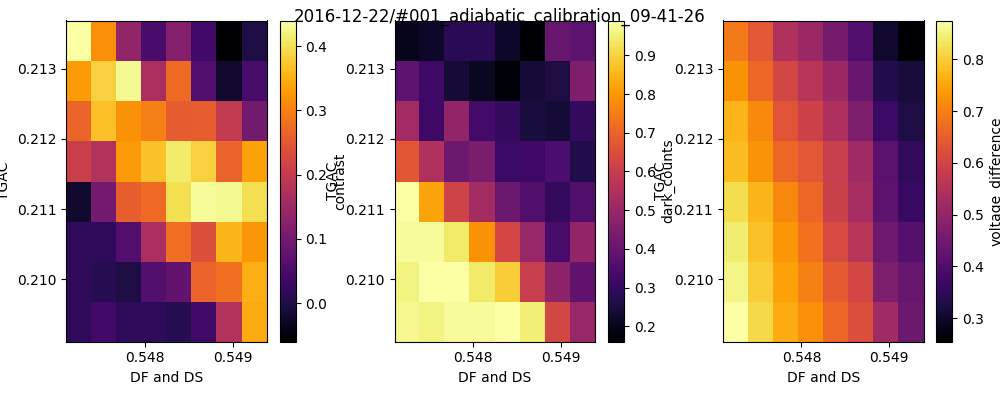

In [118]:
plot = qc.MatPlot(subplots=(1, 3), figsize=(10, 4))
plot.add(data.contrast, subplot=1)
plot.add(data.dark_counts, subplot=2)
plot.add(data.voltage_difference, subplot=3)
plt.tight_layout()

## Adiabatic - Single point

In [121]:
adiabatic_ESR_parameter.single_settings(samples=50, silent=False)
adiabatic_ESR_parameter.setup()
%time adiabatic_ESR_parameter();

contrast: 0.040
dark_counts: 0.420
voltage_difference: 0.254
Wall time: 8.09 s


[0.040000000000000036, 0.41999999999999998, 0.25367335553296744]

## Adiabatic - Compare adiabatic settings

In [ ]:
pulse = adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')


adiabatic_ESR_parameter.setup(samples=250, readout_threshold_voltage=readout_threshold_voltage,
                                save_traces=False)
data = qc.Loop(dummy_parameter[0:100:1]
              ).each(qc.Task(adiabatic_deviation_parameter, 5e6),
                     qc.Task(adiabatic_duration_parameter, .15),
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_ESR_parameter,
                     qc.Task(adiabatic_deviation_parameter, 15e6),
                     qc.Task(adiabatic_duration_parameter, .35),
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_ESR_parameter,
                    ).run(name='adiabatic_calibration',
                          progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_3_4);
plot.add(data.contrast_7_4)

## Flip nucleus

In [ ]:
# Try to flip the nucleus
adiabatic_NMR_parameter(frequency_center_NMR)
adiabatic_NMR_parameter.samples = 1
adiabatic_NMR_parameter();

## Find ESR frequency

In [ ]:
select_ESR_parameter.setup(samples=50, print_results=True, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(dummy_parameter[0:100:1]).each(qc.Task(adiabatic_NMR_parameter.setup),
                                             adiabatic_NMR_parameter,
                                             qc.Task(select_ESR_parameter.setup),
                                             select_ESR_parameter,
                                             qc.Task(adiabatic_ESR_parameter, partial(getattr, select_ESR_parameter, 'frequency_ESR')),
                                             qc.Task(adiabatic_deviation_parameter, 5e6),
                                             qc.Task(adiabatic_duration_parameter, .15),
                                             qc.Task(adiabatic_ESR_parameter.setup),
                                             adiabatic_ESR_parameter,
                                             qc.Task(adiabatic_deviation_parameter, 15e6),
                                             qc.Task(adiabatic_duration_parameter, .35),
                                             qc.Task(adiabatic_ESR_parameter.setup),
                                             adiabatic_ESR_parameter,
                                            ).run(name='test_find_ESR',
                                                 progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_up, label='nucleus up')
plot.add(data.contrast_down, label='nucleus down')
plot.add(data.contrast_8_4, label='ESR narrow')
plot.add(data.contrast_12_4, label='ESR wide')

# Dark counts

## Dark - Parameter settings

In [ ]:
dark_counts_parameter.pulse_sequence['read'].duration = 20

dark_counts_parameter.setup(readout_threshold_voltage, samples=20, print_results=True)
dark_counts_parameter.pulse_sequence

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Initialization buffers showing how long it takes before it starts plunging
plot_traces(steered_controller.initialization_traces(), ax=axes[0])
plt.title('Initialization trace\nOutput signal')

# Post initialization buffer showing if blips occurred or not
plot_traces(steered_controller.post_initialization_traces()['A'], ax=axes[1])
plt.title('Post initialization buffer\nOutput signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(steered_controller.post_initialization_traces()['C'], ax=axes[2])
plt.title('Post initialization buffer\nArbStudio signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(adiabatic_sweep_parameter.traces['output'], ax=axes[3])
plt.title('Readout trace\nOutput signal')

plt.tight_layout()

## Dark - Single point

In [ ]:
EPR_parameter.setup(samples=150, print_results=True)
EPR_parameter();

# Read level sweep (to be fixed)

In [ ]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

In [ ]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

## T1 - Single point

In [ ]:
T1_parameter(10000)
T1_parameter.print_results = True
%time up_proportion,number_traces_loaded = T1_parameter()

## T1 - single scan

In [88]:
# Calculate T1 durations
T1_wait_times = list(np.logspace(1, 4, num=10, base=10))

# Shuffle times
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [10.0, 21.544346900318832, 46.415888336127772, 100.0, 215.44346900318823, 464.15888336127773, 1000.0, 2154.4346900318824, 4641.5888336127773, 10000.0]


In [91]:
T1_parameter.pulse_sequence['read'].duration=20

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-21/#005_T1_single_sweep_19-42-08'
   <Type>   | <array_id>           | <array.name>     | <array.shape>
   Setpoint | T1_wait_time_ESR_set | T1_wait_time_ESR | (10,)
   Measured | up_proportion        | up_proportion    | (10,)
   Measured | num_traces           | num_traces       | (10,)
started at 2016-12-21 19:42:10


<IPython.core.display.Javascript object>


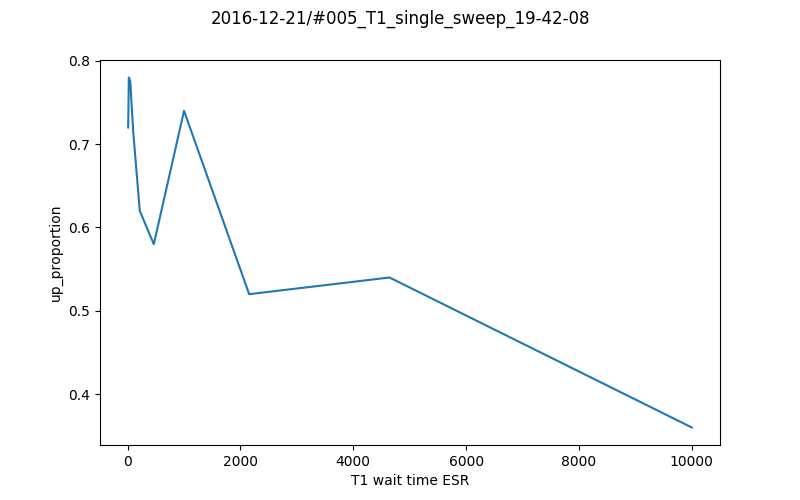

In [92]:
# Single T1 sweep
T1_parameter.samples=50
data = qc.Loop(
    T1_parameter[T1_wait_times]).each(
    T1_parameter).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

## T1 - Multiple scans

In [108]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1, 4.1, num=12, base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [3438.4573069455232, 12589.254117941662, 19.134546859970403, 490.80512716538561, 70.057485479096783, 36.613088353640322, 134.05182387914726, 256.50209056800458, 10.0, 6579.3322465756755, 1796.9891485325938, 939.13337048598044]


In [113]:
T1_parameter.samples = 50
dark_counts_parameter.samples = 100
adiabatic_ESR_parameter.samples = 100
data = qc.Loop(
    dummy_parameter[0:80:1]).each(
    adiabatic_ESR_parameter,
    dark_counts_parameter,
    qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter),
                    ).run(name='T1_data', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-21/#010_T1_data_20-52-59'
   <Type>   | <array_id>           | <array.name>       | <array.shape>
   Setpoint | dummy_set            | dummy              | (80,)
   Measured | contrast             | contrast           | (80,)
   Measured | dark_counts_0_1      | dark_counts        | (80,)
   Measured | voltage_difference   | voltage_difference | (80,)
   Measured | dark_counts_1        | dark_counts        | (80,)
   Setpoint | T1_wait_time_ESR_set | T1_wait_time_ESR   | (80, 12)
   Measured | up_proportion        | up_proportion      | (80, 12)
   Measured | num_traces           | num_traces         | (80, 12)
started at 2016-12-21 20:53:02


<IPython.core.display.Javascript object>


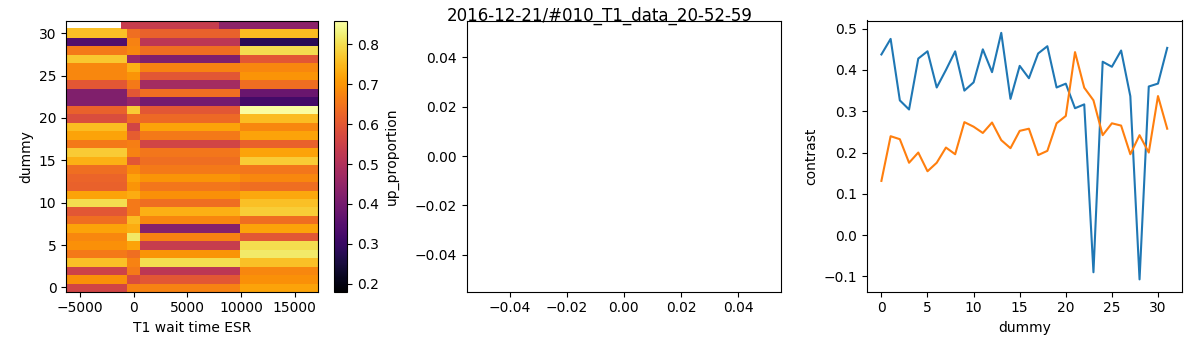

In [115]:
plot = qc.MatPlot(subplots=(1,3), figsize=(12,3.5))
plot.add(data.up_proportion, subplot=1)
# plot.subplots[0].set_xscale('log')
# plot.add(data.T1_wait_time_set[0], np.nanmean(data.up_proportion_5_0_0, axis=0), subplot=2)
# plot.subplots[1].set_xscale('log')
# plot.subplots[1].set_xlim(10, 13000)
plot.add(data.contrast, subplot=3)
plot.add(data.dark_counts_1, subplot=3)
plt.tight_layout()

## T1 - Plunge voltage scan
This scan measures the contrast for a fixed wait time as the plunge voltage is varied

In [ ]:
plunge_voltage_parameter = general_parameters.AttributeParameter(
    object=T1_parameter.pulse_sequence['plunge'],
    attribute='voltage')

In [ ]:
select_ESR_parameter.setup(samples=30, silent=True)
T1_parameter.setup(samples=40, silent=True)
adiabatic_ESR_parameter.setup(samples=150, silent=True)
dark_counts_parameter.setup(samples=250, silent=True)

T1_parameter(1200)
data = qc.Loop(dummy_parameter[0:70:1]
               ).each(qc.Loop(plunge_voltage_parameter[1:2.5:0.1]
                              ).each(qc.Task(select_ESR_parameter.setup),
                                     select_ESR_parameter,
                                     qc.Task(T1_parameter.setup),
                                     T1_parameter),
                      autocal_parameter,
                      qc.Task(dark_counts_parameter.setup),
                      dark_counts_parameter
                     ).run(name='T1_plunge_voltage', progress_interval=True)

## T1 - Analysis

In [ ]:
T1_msmt = T1_Measurement(B0=1.2, location='2016-11-24/#006_T1_data_12-19-40')
T1_msmt.plot_T1()
print(T1_msmt.fit_result.fit_report())

In [ ]:
#data.arrays['up_proportion']
data.T1_wait_time_set[0]

In [ ]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=readout_threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

In [ ]:
data.sync()
print(data.T1_wait_time_set[0])
data.up_proportion_3_0_0[29]

# Plotting

In [ ]:
## Adiabatic - Detailed plot
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Notes

To save individual traces when performing a measurement, set:
    
EPR_parameter.setup(samples=100, data_manager=data_manager_raw)

In [ ]:
steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['load'].t_stop=15

In [ ]:
adiabatic_sweep_parameter.steered_initialization

In [ ]:
steered_controller.record_initialization_traces

To enable/disable steered initialization, use:

adiabatic_sweep_parameter.steered_intialization = True/False

This adds/removes the steered initialization "pulse" from the EPR_parameter.pulse_sequence
If steered_initialization is enabled, you can access and modify its properties via

steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

Note that steered initialization is currently only implemented for the adiabatic sweep, but is easy to add for other parameters, such as T1_parameter (just add the pulse)

steered_controller is the acquisition controller specifically for steered initialization
You can look at the initialization traces when using steered initialization.

First set the flag 
steered_controller.record_initialization_traces(True)

The initialization traces can then be accessed
steered_controller.initialization_traces()

You can also look at the first buffer after the pulseblaster.start() command has been set via
steered_controller.post_initialization_traces()
This can be useful for checking the delay between sending the command and plunging

To setup a parameter where steered initialization is enabled, you must pass it a readout threshold voltage every time.

adiabatic_sweep_parameter.setup(readout_threshold_voltage=threshold_voltage)

This threshold voltage can be obtained from an EPR scan (see T1_measurement):

EPR_parameter.setup(samples=30)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)

In [ ]:
adiabatic_sweep_parameter.pulse_sequence.add(adiabatic_sweep_parameter._steered_initialization)
adiabatic_sweep_parameter.pulse_sequence.remove(adiabatic_sweep_parameter._steered_initialization)

To save raw traces, use:

EPR_parameter.setup(save_traces=True, data_manager=data_manager_raw)